In [563]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg

## Load Data

In [564]:
df = pd.read_excel("data/data.xlsx")
df.head()

,Date,LC2A,MP2,MP1,MC
0,22/10/2025 18:00,721.0,870.75,845.12,850.2
1,22/10/2025 20:00,650.0,760.20,848.10,889.8
2,22/10/2025 22:30,644.0,638.40,749.00,682.3
3,23/10/2025 01:00,636.0,552.70,741.00,658.2
4,23/10/2025 04:00,649.0,607.42,755.40,670.2


In [565]:
cols = ['Date', 'LC2A', 'MP2', 'MP1', 'MC']

data = df[cols].melt(id_vars='Date', var_name='group', value_name='value').sort_values(by='Date')
data.head(6)

,Date,group,value
0,22/10/2025 18:00,LC2A,721.00
69,22/10/2025 18:00,MC,850.20
46,22/10/2025 18:00,MP1,845.12
23,22/10/2025 18:00,MP2,870.75
1,22/10/2025 20:00,LC2A,650.00
47,22/10/2025 20:00,MP1,848.10


In [570]:
data.groupby('group')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
LC2A,19.0,716.947368,60.875532,636.0,660.00,721.00,772.000,811.00
MC,23.0,711.901304,84.157592,566.0,673.35,700.55,771.375,889.80
MP1,23.0,731.074348,60.525671,626.0,683.49,742.00,755.200,848.10
MP2,23.0,686.379130,87.209891,535.0,628.35,680.00,740.400,870.75


## Data Visualization

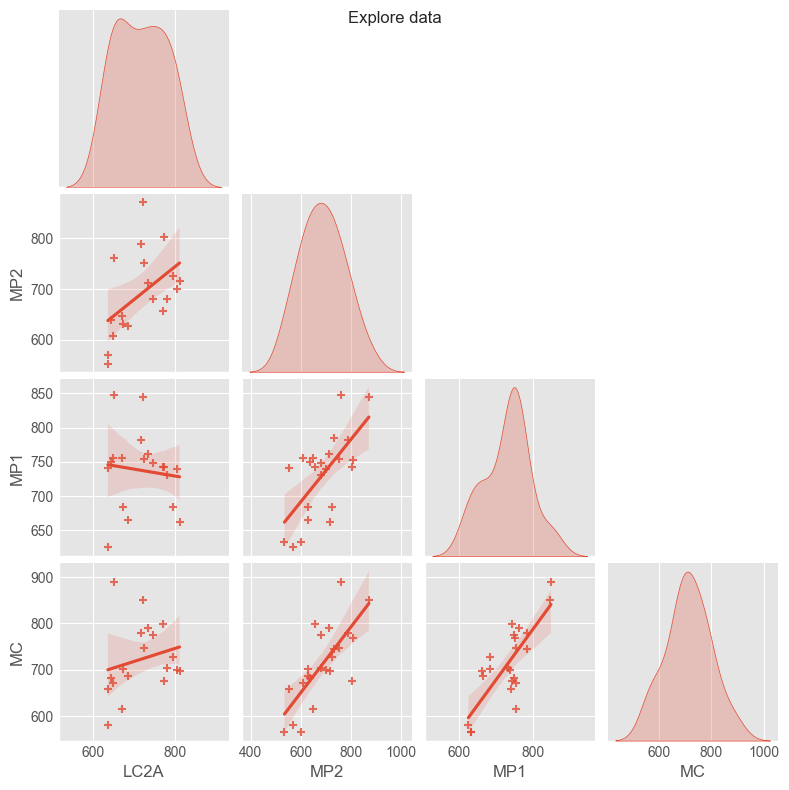

In [571]:
plt.style.use("ggplot")
sns.pairplot(df[cols], height=2, kind='reg', diag_kind='kde', markers='+', corner=True)
plt.suptitle("Explore data")
plt.show()

In [576]:
# check dependency between groups
pg.corr(df)


TypeError: corr() missing 1 required positional argument: 'y'

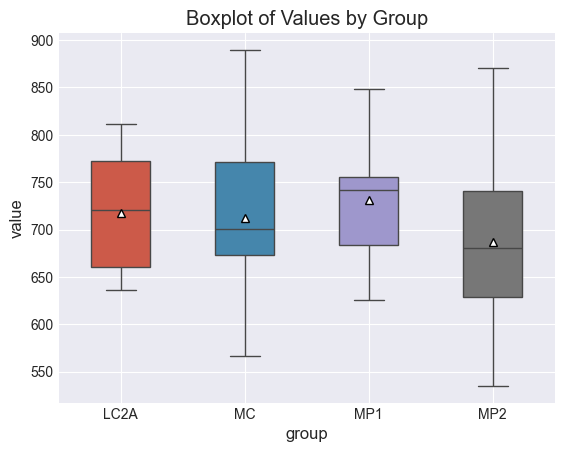

In [572]:
plt.style.use("seaborn-v0_8-dark")
sns.boxplot(
    data=data,
    x="group",
    y="value",
    hue="group",
    # show means
    showmeans=True,
    meanprops={
        "marker": "^",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "6",
    },
    gap=1.6,
)
plt.grid(True)
plt.title("Boxplot of Values by Group")
plt.show()

## Assumptions Check

### Dependency check

In [573]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

def check_dependency_assumption(df: pd.DataFrame, dv='value', group='group') -> tuple[float, float, bool]:
    """
    Checks for dependency in the data using Durbin-Watson and Ljung-Box tests.
    The Ljung-Box test is performed for lags 1, 2, and 3.

    Args:
        data (dict): A dictionary containing 'group' and 'growth' data.

    Returns:
        tuple[float, float, bool]: A tuple containing:
            - dw_statistic (float): The Durbin-Watson statistic.
				dw close to 2 suggests no autocorrelation.
    			Values < 2 indicate positive autocorrelation,
				while values > 2 indicate negative autocorrelation.
            - min_ljung_box_pvalue (float): The minimum p-value from the Ljung-Box test across lags 1-3.
				p-value < 0.05 suggests significant autocorrelation at that lag.
            - dependency_result (bool): True if dependency is detected, False otherwise.
    """
    # 1. The formula 'growth ~ C(group)' treats 'group' as a categorical variable
    model = ols(f'{dv} ~ C({group})', data=df.dropna()).fit()
    
    # 2. Calculate the Durbin-Watson statistic from the model residuals
    dw_statistic = durbin_watson(model.resid)
    
    # 3. Perform the Ljung-Box test on the model residuals for lags 1, 2, and 3
    lags_to_test = [1, 2, 3]
    ljung_box_result = acorr_ljungbox(model.resid, lags=lags_to_test, return_df=False)
    display(ljung_box_result)
    
    # Get the minimum p-value from the tested lags
    min_ljung_box_pvalue = ljung_box_result['lb_pvalue'].min()
    
    # 4. Determine the dependency result
    # Check if any of the Ljung-Box p-values are significant
    is_ljung_box_significant = (ljung_box_result['lb_pvalue'] < 0.05).any()
    
    # Dependency is suspected if DW is far from 2 OR any Ljung-Box p-value is significant
    dependency_result = bool((dw_statistic < 1.5 or dw_statistic > 2.5) or is_ljung_box_significant)
    
    return dw_statistic, min_ljung_box_pvalue, dependency_result

# --- Example Usage ---


# Get the results
dw_stat, lb_p, dependency = check_dependency_assumption(data)

# Print the results
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
print(f"Minimum Ljung-Box p-value (lags 1-3): {lb_p:.4f}")
print(f"Dependency Detected: {dependency}")

,lb_stat,lb_pvalue
1,30.046394,4.218322e-08
2,56.767651,4.710437e-13
3,78.729756,5.747447e-17


Durbin-Watson Statistic: 0.8507
Minimum Ljung-Box p-value (lags 1-3): 0.0000
Dependency Detected: True


### Normality & Homoscedasticity Assumptions Check

In [477]:
normality_result = pg.normality(data=data, dv='value', group='group', method='shapiro')
is_all_normal = normality_result.all(bool_only=True).iat[0]
normality_result

,W,pval,normal
group,,,
LC2A,0.919723,0.111841,True
MC,0.971725,0.730211,True
MP1,0.921319,0.071101,True
MP2,0.985983,0.979343,True


In [478]:
equal_var_test_result = pg.homoscedasticity(data.dropna(), dv='value', group='group')
is_equal_var = equal_var_test_result.all(bool_only=True).iat[0]
equal_var_test_result

,W,pval,equal_var
levene,1.622377,0.1903,True


In [479]:
if is_all_normal:
    test_category = 'parametric'
    if is_equal_var:
        method = 'classic'
        poste_hoc = 'tukey-hsd'
else:
    test_category = 'parametric'
    if is_equal_var:
        method = 'welch'
        poste_hoc = 'gameshowell'

print(f"ANOVA method: {method},\nPost-hoc test: {poste_hoc}")

ANOVA method: classic,
Post-hoc test: tukey-hsd


In [408]:
classic_anova = pg.anova(data, dv='value', between='group')
tukey_hsd = pg.pairwise_tukey(data, dv='value', between='group')
display(classic_anova)
tukey_hsd

,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,84,1.422028,0.242084,0.048332


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,LC2A,MC,716.947368,711.901304,5.046064,23.200357,0.217499,0.996339,0.066378
1,LC2A,MP1,716.947368,731.074348,-14.126979,23.200357,-0.608912,0.928983,-0.228406
2,LC2A,MP2,716.947368,686.379130,30.568238,23.200357,1.317576,0.554438,0.392098
3,MC,MP1,711.901304,731.074348,-19.173043,22.067941,-0.868819,0.820902,-0.257085
4,MC,MP2,711.901304,686.379130,25.522174,22.067941,1.156527,0.655720,0.292712
5,MP1,MP2,731.074348,686.379130,44.695217,22.067941,2.025346,0.186961,0.585228


In [420]:
kw_result = pg.kruskal(data, dv='value', between='group')
pval = kw_result['p-unc'].values[0]
print(f"Kruskal-Wallis H-test p-value: {pval}")
if pval < 0.05:
	print("Significant differences detected between groups. Proceeding with post-hoc test.")
	post_hoc = pg.pairwise_tests(data, dv='value', between='group', parametric=False, padjust='bonferroni')
	display(post_hoc)
else:
	print("No significant differences detected between groups.")

Kruskal-Wallis H-test p-value: 0.26734084796910623
No significant differences detected between groups.


In [419]:
pg.pairwise_tests(data, dv='value', between='group', parametric=False, padjust='bonferroni')

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,group,LC2A,MC,False,False,221.5,two-sided,0.949620,1.000000,bonferroni,0.066378
1,group,LC2A,MP1,False,False,193.0,two-sided,0.527490,1.000000,bonferroni,-0.228406
2,group,LC2A,MP2,False,False,271.0,two-sided,0.188804,1.000000,bonferroni,0.392098
3,group,MC,MP1,False,False,229.0,two-sided,0.441898,1.000000,bonferroni,-0.257085
4,group,MC,MP2,False,False,309.0,two-sided,0.333707,1.000000,bonferroni,0.292712
5,group,MP1,MP2,False,False,355.0,two-sided,0.048002,0.288014,bonferroni,0.585228
